In [33]:
##Carregar llibreries
import pandas as pd         ###py -m pip install pandas
import numpy as np ###py -m pip install numypy

from sklearn.decomposition import PCA ###py -m pip install scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
#from sklearn.model_selection import train_test_split
from yellowbrick.cluster import KElbowVisualizer ##py -m pip install yellowbrick
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

import seaborn as sns ##py -m pip install seaborn

import matplotlib.pyplot as plt ##py -m pip install matplotlib

In [37]:
df = pd.read_csv('SpotifyFeatures.csv')
print(f"Mostra: {df.head()}")
print(f"Info: {df.info()}")

##Preparar dades
#1) Treure cançons duplicades
#Quantitat duplicats
print("Quantitat de dupplicats:", df.duplicated(subset="track_id", keep="first").sum())

#Treure duplicats
df = df.drop_duplicates(subset="track_id", keep="first")
print(f"Nova shape: {df.shape}")

#2) Eliminar columnes innecesàries
#Columnes: 'artist_name','track_name','track_id 
df.drop(['artist_name','track_name','track_id'], axis=1, inplace=True) 
print(f"Nova shape: {df.shape}")

#3) Corretgir valors errònis (impossibles)
#Comprovar valors de key, mode i time_signature
print("Key values:", df['key'].value_counts())
print("Mode values:", df["mode"].value_counts())
print("Time_signature values:", df["time_signature"].value_counts())

#Substituir 0/4 (impossible) per 4/4 (més comú)
df["time_signature"] = df['time_signature'].replace('0/4','4/4')
print("Nova shape:", df["time_signature"].value_counts())

#4) Codificar columnes no numèriques
#Codificar columna key 
freq = df["key"].value_counts(normalize=True)
df["key"] = df["key"].map(freq)

#Codificar columna mode 
freq = df["mode"].value_counts(normalize=True)
df["mode"] = df["mode"].map(freq)

#Codificar columna time_signature
freq = df["time_signature"].value_counts(normalize=True)
df["time_signature"] = df["time_signature"].map(freq)

#Codificar columna time_signature
freq = df["genre"].value_counts(normalize=True)
df["genre"] = df["genre"].map(freq)
print("Mostra:", df.head())

##Establir model
#1) Dividir train i test
#Dividir train i test
data = df.copy()


Mostra:    genre        artist_name                        track_name  \
0  Movie     Henri Salvador       C'est beau de faire un Show   
1  Movie  Martin & les fées  Perdu d'avance (par Gad Elmaleh)   
2  Movie    Joseph Williams    Don't Let Me Be Lonely Tonight   
3  Movie     Henri Salvador    Dis-moi Monsieur Gordon Cooper   
4  Movie       Fabien Nataf                         Ouverture   

                 track_id  popularity  acousticness  danceability  \
0  0BRjO6ga9RKCKjfDqeFgWV           0         0.611         0.389   
1  0BjC1NfoEOOusryehmNudP           1         0.246         0.590   
2  0CoSDzoNIKCRs124s9uTVy           3         0.952         0.663   
3  0Gc6TVm52BwZD07Ki6tIvf           0         0.703         0.240   
4  0IuslXpMROHdEPvSl1fTQK           4         0.950         0.331   

   duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0        99373   0.910             0.000  C#    0.3460    -1.828  Major   
1       137373   0.737             0

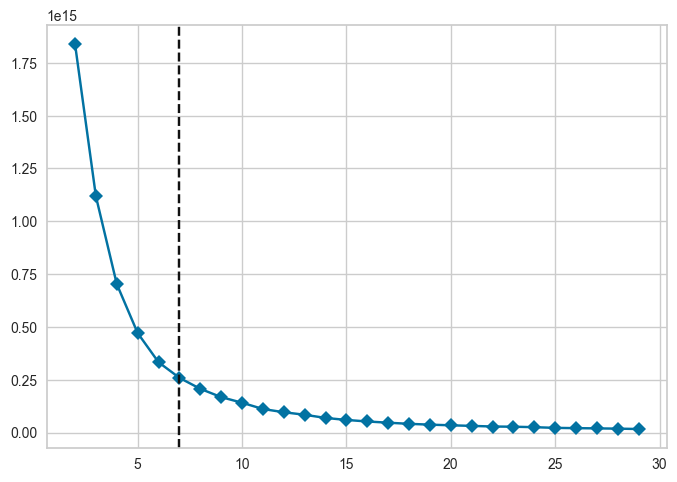

In [38]:
#2) Calcular k millor
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,30), timings=False, metric='distortion')
visualizer.fit(data)       
#visualizer.show()        
k = visualizer.elbow_value_ #millor k

#3) Fer amb Scaler (mateix rang totes feature) i KMeans 
scaler = StandardScaler()
data_scal = scaler.fit_transform(data)

kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)

#4) Entrenar i predir 
pred = kmeans.fit_predict(data_scal)

##Visualitzar pred
#1) Reduir components a 2 amb PCA
pca = PCA(n_components=2)
data_2 = pca.fit_transform(data_scal)

#Mirar la rellevàcia de cada feature en el càlcul de la component i la variancia per component
#pd.DataFrame(data=pca.components_, columns=x_train_scal.columns, index=['C1', 'C2'])
#pca.explained_variance_ratio.cumsum()

#Crear dataframe per visualitzar 
df_2 = pd.DataFrame(data_2, columns=['Component 1', 'Component 2'])
df_2["cluster"] = pred

740.3508038366689 81.11420989264056


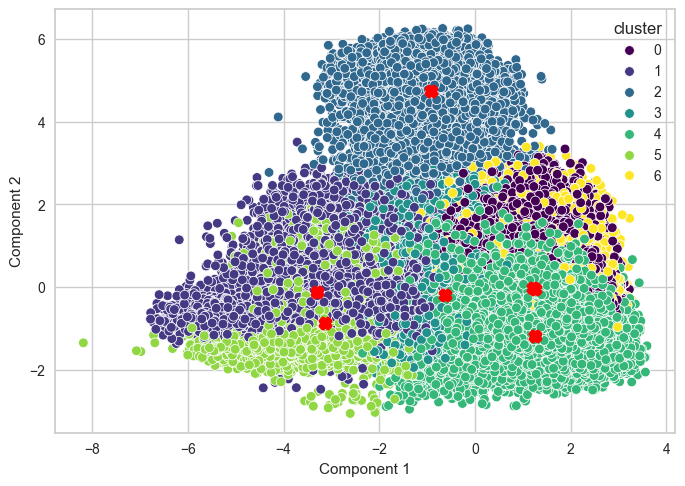

In [36]:
#2) Scatterplot (en jupyter)
##Plot les dades train
print(calinski_harabasz_score(data, kmeans.labels_), davies_bouldin_score(data, kmeans.labels_))
center = pca.transform(kmeans.cluster_centers_)
sns.scatterplot(data=df_2, x='Component 1', y='Component 2', hue='cluster', palette='viridis')##Plot les dades test
plt.scatter([c[0] for c in center],[c[1] for c in center], marker='X', linewidths=3, color='red')
plt.show()